In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as ks
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Bidirectional, Lambda, Input
from tensorflow.keras.models import Model
plt.style.use('default')
plt.style.use('ggplot')

In [2]:
df = pd.read_csv('TSLA.csv')
print(df.shape)
df.head()

(2416, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


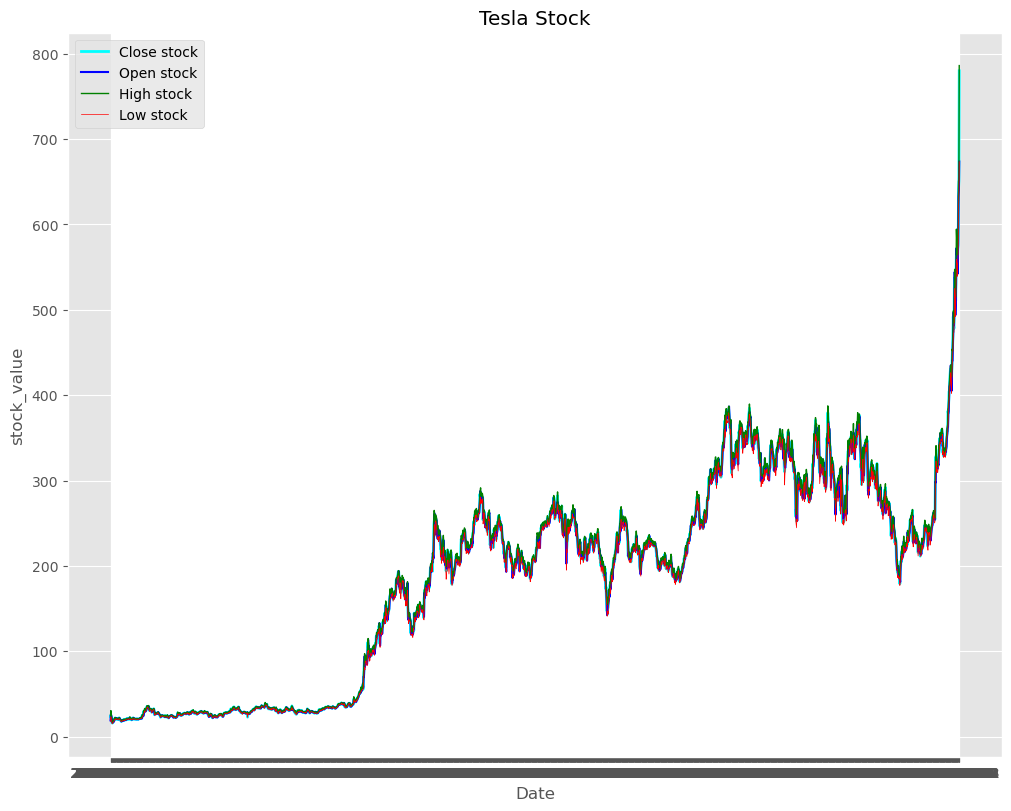

In [3]:
plt.figure(figsize=(10, 8), constrained_layout=True)
c = ['cyan', 'blue', 'green', 'red']
y = ['Close', 'Open', 'High', 'Low']
l = 2.0
for j, c in zip(y, c):
  plt.plot(df['Date'], df[j], color=c, linewidth=l, label=f'{j} stock')
  plt.title('Tesla Stock')
  plt.xlabel('Date')
  plt.ylabel('stock_value')
  plt.legend()
  l -=0.5

plt.show()

In [4]:
from PyEMD import CEEMDAN, Visualisation

In [5]:
close = df[['Close']].values

In [9]:
close

array([[ 23.889999],
       [ 23.83    ],
       [ 21.959999],
       ...,
       [640.809998],
       [650.570007],
       [780.      ]])

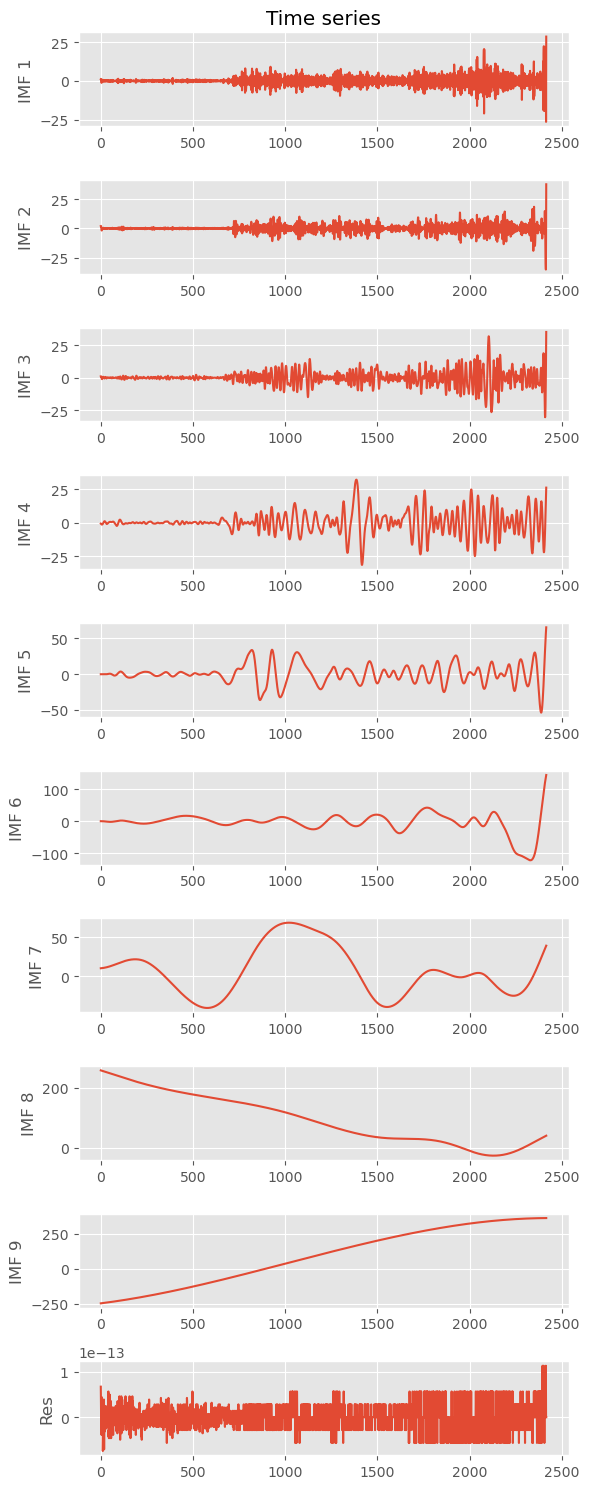

In [6]:
ceemdan = CEEMDAN()
ceemdan.ceemdan(close.reshape(-1))
imfs_close, res_close = ceemdan.get_imfs_and_residue()

t = np.arange(0, 2416, 1)
vis = Visualisation()
vis.plot_imfs(imfs=imfs_close, residue=res_close, t=t, include_residue=True)
# vis.plot_instant_freq(t, imfs=imfs)
vis.show()

In [7]:
imfs_close[0]

array([  1.11744991,   1.06726636,   0.51836037, ...,  21.82756114,
       -26.33055902,  28.52749098])

In [8]:
# 取之前X_lag个数据来预测下一个数据
def time_slice(data,X_lag):
    sample = []
    label = []
    for k in range(len(data) - X_lag - 1):
        t = k + X_lag
        sample.append(data[k:t])
        label.append(data[t + 1])
    return sample,label


In [9]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import time

In [10]:
def implement_BP(X_train, y_train):
    param_grid = {'hidden_layer_sizes': [(3,), (10,), (30,), (9,), (20,)], 'learning_rate_init': [0.001, 0.1, 0.2, 0.3, 0.01],
                  'max_iter': [8000]}
    model = MLPRegressor()
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    print(grid_search.best_estimator_)
    print(grid_search.best_params_)
    
#     model = MLPRegressor(hidden_layer_sizes=(10,), random_state=10, learning_rate_init=0.1)  # BP神经网络回归模型
#     model.fit(X_train,y_train)  # 训练模型
    
    return grid_search.best_estimator_

In [41]:
def split(sample, label, test_ratio):
    length = len(label)
    train_len = round((1-test_ratio)*length)
    test_len = round(test_ratio*length)
    print(test_len)
    print(train_len)
#     X_train = sample[0:train_len]
#     X_test = sample[train_len+1:length]
#     y_train = label[0:train_len]
#     y_test = label[train_len+1:length]

    X_test = sample[200:test_len+200]
    X_train = sample[0:200]
    print(len(X_train))
    for i in range(test_len+200,length):
        X_train.append(sample[i])
    
    y_test = label[200:test_len+200]
    y_train = label[0:200]
    for j in range(test_len+200,length):
        y_train.append(label[j])
    
    return X_train, X_test, y_train, y_test

In [42]:
sample,label = time_slice(imfs_close[0],30)
X_train, X_test, y_train, y_test = split(sample, label, 0.2)

477
1908
200


In [43]:
print(len(X_test))
print(len(X_train))

477
1908


In [44]:
i = 1
svr = []
prediction = []
actual = []

for imf in imfs_close:
#     print('-'*45)
#     print('This is  ' + str(i)  + '  time(s)')
#     print('*'*45)
    
    # 生成time series dataset
    sample,label = time_slice(imf,30)
    
    # 数据集划分
#     X_train, X_test, y_train, y_test = train_test_split(sample, label, test_size=0.2, random_state=42)
    X_train, X_test, y_train, y_test = split(sample, label, 0.2)
    tmp = implement_BP(X_train, y_train)
    
    svr.append(tmp)
    actual.append(y_test)
    
    pre_tmp = tmp.predict(X_test)
    prediction.append(pre_tmp)
    
    i=i+1

477
1908
200
MLPRegressor(hidden_layer_sizes=(3,), learning_rate_init=0.3, max_iter=8000)
{'hidden_layer_sizes': (3,), 'learning_rate_init': 0.3, 'max_iter': 8000}
477
1908
200
MLPRegressor(hidden_layer_sizes=(3,), learning_rate_init=0.01, max_iter=8000)
{'hidden_layer_sizes': (3,), 'learning_rate_init': 0.01, 'max_iter': 8000}
477
1908
200
MLPRegressor(hidden_layer_sizes=(3,), max_iter=8000)
{'hidden_layer_sizes': (3,), 'learning_rate_init': 0.001, 'max_iter': 8000}
477
1908
200
MLPRegressor(hidden_layer_sizes=(10,), learning_rate_init=0.01, max_iter=8000)
{'hidden_layer_sizes': (10,), 'learning_rate_init': 0.01, 'max_iter': 8000}
477
1908
200
MLPRegressor(hidden_layer_sizes=(3,), learning_rate_init=0.01, max_iter=8000)
{'hidden_layer_sizes': (3,), 'learning_rate_init': 0.01, 'max_iter': 8000}
477
1908
200
MLPRegressor(hidden_layer_sizes=(20,), max_iter=8000)
{'hidden_layer_sizes': (20,), 'learning_rate_init': 0.001, 'max_iter': 8000}
477
1908
200
MLPRegressor(hidden_layer_sizes=(30,)

In [14]:
prediction

[array([ -0.04455633,  -0.04455633,  -1.85720222,  -0.04455633,
         -0.04455633,  -2.10088535,  -0.11291446,  -1.68501499,
         -0.04455633,   3.48829786,  -3.71940181,  -1.40929059,
          3.01953556,  -4.1668772 ,  -0.04455633,   4.58075416,
         -2.78083092,  -7.15229398,  -2.0018958 ,   3.811278  ,
         -2.32203908,  -0.04455633,   0.17695729,  -0.04455633,
         -0.68108718,   1.00795782,  -0.04455633,  -4.75440818,
          0.22693341,   2.81730565,  -3.21859868,  -0.04455633,
          1.41789548,  -0.04455633,   1.21362496,  -0.82624397,
         -0.04455633,  -0.04455633,  -4.11405518,  -0.04455633,
         -0.26266743,  -1.8305043 ,  -2.44822152,  -0.04455633,
          0.78055518,   2.71844576,  -0.04455633,  -0.80967472,
          0.69591775,  -0.04455633,  -0.04455633,  -1.30561261,
         -0.04455633,  -0.04455633,   0.28767882,  -0.04455633,
         -0.04455633,  -0.04455633,  -1.27392727,   2.02850457,
         -3.01650578,  -0.04455633,   2.

In [45]:
mean_pre = []

for i in range(0,len(prediction[0])):
    sum = 0
    for j in range(0,len(prediction)):
        sum = sum + prediction[j][i]
    
    mean = sum/len(prediction)
    mean_pre.append(mean)
        
mean_pre        

[3.264265103695089,
 3.2356566444419994,
 3.2272475874908997,
 3.171020372836441,
 3.1250204632251646,
 3.225992588720544,
 3.0681406644746434,
 3.0215369226132003,
 2.9666007021905454,
 3.0021490103177846,
 3.089520194786802,
 3.0844341373663977,
 3.0378972309922605,
 3.004519795189209,
 2.8037041010153225,
 2.93087792221954,
 2.8908600966385496,
 3.033081488261372,
 3.024216323469378,
 3.0181267404464904,
 3.029882615534777,
 3.024422048507628,
 3.102715476481557,
 3.1507463051759306,
 3.1241793039827552,
 3.2593893495853132,
 3.156749048813664,
 3.2541954115718728,
 3.1933032224763545,
 3.1102049481886556,
 3.0888977254711656,
 3.017779455662056,
 3.0764587647617123,
 3.0109274976741554,
 2.9562961191174395,
 3.0060762624626958,
 3.079735838478576,
 3.1343301134791566,
 3.1555967611050133,
 3.1207624858821155,
 3.092789013607122,
 2.970609389651271,
 3.0464572595951216,
 3.0536912074301106,
 3.0260501215109503,
 3.071145461825523,
 2.8036183718393803,
 2.7978631337239883,
 2.5979511

In [46]:
mean_actual = []

for i in range(0,len(actual[0])):
    sum = 0
    for j in range(0,len(actual)):
        sum = sum + actual[j][i]
    
    mean = sum/len(actual)
    mean_actual.append(mean)
        
mean_actual    

[3.2833332222222205,
 3.3488887777777765,
 3.16888888888889,
 3.1955555555555546,
 3.3477776666666665,
 3.1888889999999983,
 3.1522223333333335,
 3.0133334444444446,
 3.0688890000000035,
 3.0955556666666677,
 3.1588888888888897,
 3.177777777777777,
 3.035555555555558,
 2.9444444444444446,
 2.9444444444444446,
 2.8900000000000023,
 3.058889000000003,
 3.0233332222222202,
 3.0788887777777756,
 3.0633333333333326,
 3.051111000000001,
 3.123333444444446,
 3.143333444444443,
 3.2366665555555523,
 3.224444444444446,
 3.2377776666666684,
 3.217777666666668,
 3.3033333333333323,
 3.2011109999999974,
 3.1499999999999995,
 3.1300000000000017,
 3.182222111111107,
 3.06777788888889,
 3.0644444444444425,
 3.025555555555554,
 3.0988887777777765,
 3.1877778888888915,
 3.1888889999999983,
 3.2544445555555575,
 3.1655555555555535,
 3.111111111111111,
 3.071111000000002,
 3.1299999999999986,
 3.1299999999999986,
 3.1966666666666677,
 3.0377777777777784,
 3.022222333333335,
 2.75,
 2.693333333333331,
 2.

In [47]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("mean_absolute_error:", mean_absolute_error(mean_actual, mean_pre))
print("mean_squared_error:", mean_squared_error(mean_actual, mean_pre))
print("rmse:", sqrt(mean_squared_error(mean_actual, mean_pre)))
print("r2 score:", r2_score(mean_actual, mean_pre))

mean_absolute_error: 0.09775636188841162
mean_squared_error: 0.01372020245734565
rmse: 0.11713326793590986
r2 score: 0.9434835478243532


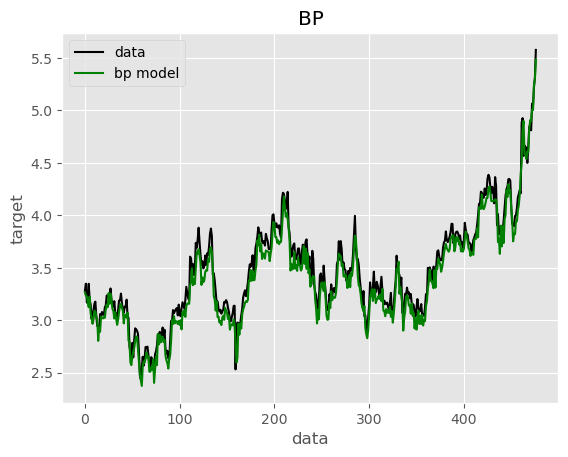

In [48]:
plt.plot(mean_actual,c='k',label='data')
plt.plot(mean_pre,c='g',label='bp model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('BP')
plt.legend()
plt.show()


In [49]:
# 傻瓜算法
stupid_actual = mean_actual
stupid_predict = [stupid_actual[0]]
stupid_predict[1:len(stupid_actual)] = stupid_actual[0:len(stupid_actual)-1]
print(len(stupid_actual))
print(len(stupid_predict))
print(stupid_actual)
print(stupid_predict)

477
477
[3.2833332222222205, 3.3488887777777765, 3.16888888888889, 3.1955555555555546, 3.3477776666666665, 3.1888889999999983, 3.1522223333333335, 3.0133334444444446, 3.0688890000000035, 3.0955556666666677, 3.1588888888888897, 3.177777777777777, 3.035555555555558, 2.9444444444444446, 2.9444444444444446, 2.8900000000000023, 3.058889000000003, 3.0233332222222202, 3.0788887777777756, 3.0633333333333326, 3.051111000000001, 3.123333444444446, 3.143333444444443, 3.2366665555555523, 3.224444444444446, 3.2377776666666684, 3.217777666666668, 3.3033333333333323, 3.2011109999999974, 3.1499999999999995, 3.1300000000000017, 3.182222111111107, 3.06777788888889, 3.0644444444444425, 3.025555555555554, 3.0988887777777765, 3.1877778888888915, 3.1888889999999983, 3.2544445555555575, 3.1655555555555535, 3.111111111111111, 3.071111000000002, 3.1299999999999986, 3.1299999999999986, 3.1966666666666677, 3.0377777777777784, 3.022222333333335, 2.75, 2.693333333333331, 2.6266665555555573, 2.784444333333331, 2.64

In [50]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("mean_absolute_error:", mean_absolute_error(stupid_actual, stupid_predict))
print("mean_squared_error:", mean_squared_error(stupid_actual, stupid_predict))
print("rmse:", sqrt(mean_squared_error(stupid_actual, stupid_predict)))
print("r2 score:", r2_score(stupid_actual, stupid_predict))

mean_absolute_error: 0.07953877474959253
mean_squared_error: 0.012629068508446454
rmse: 0.11237912843783072
r2 score: 0.9479781622319686


In [51]:
trend_actual = []

for i in range(1, len(mean_actual)):
    tmp = mean_actual[i] - mean_actual[i-1]
    if tmp < 0: # down
        trend_actual.append(2)
    elif tmp > 0: # up
        trend_actual.append(0)
    else:
        trend_actual.append(1)

print(len(trend_actual))
trend_actual

476


[0,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 1,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 1,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,


In [52]:
trend_predict = []

for i in range(1, len(mean_pre)):
    tmp = mean_pre[i] - mean_pre[i-1]
    if tmp < 0: # down
        trend_predict.append(2)
    elif tmp > 0: # up
        trend_predict.append(0)
    else:
        trend_predict.append(1)

trend_predict

[2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 0,
 0,


In [23]:
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("mean_absolute_error:", mean_absolute_error(trend_actual, trend_predict))
print("mean_squared_error:", mean_squared_error(trend_actual, trend_predict))
print("rmse:", sqrt(mean_squared_error(trend_actual, trend_predict)))
print("r2 score:", r2_score(trend_actual, trend_predict))

mean_absolute_error: 0.6652631578947369
mean_squared_error: 1.3305263157894738
rmse: 1.1534844237307558
r2 score: -0.33067375886524863


In [53]:
same = 0
up = []

for i in range(0, len(trend_actual)):
    if trend_actual[i] == trend_predict[i]:
        same = same + 1
        tmp = abs(mean_actual[i+1]-mean_actual[i])
        up.append(tmp)
        
ratio = same/len(trend_actual)
ratio

0.5945378151260504

In [29]:
up

[0.128749875000004,
 0.5312499999999929,
 0.973751,
 0.3762512500000028,
 0.9287491250000031,
 0.9449996250000012,
 3.125,
 2.674999249999999,
 2.426250374999988,
 2.347499875000004,
 0.8025016249999979,
 1.2049979999999962,
 0.856250750000001,
 1.1412506249999979,
 0.707500500000009,
 0.8412476249999941,
 1.229999625000005,
 0.858749374999995,
 0.011249500000005241,
 1.0749970000000033,
 0.15374762500000116,
 2.08749774999999,
 1.2049979999999962,
 1.084999124999996,
 0.610000625000005,
 0.22875212499999975,
 0.4949988750000003,
 1.1362496249999978,
 0.973751,
 0.9650002499999886,
 0.5074996249999941,
 0.1525001250000031,
 0.125,
 0.613750500000009,
 0.9949988749999861,
 0.8862494999999981,
 0.6149978750000002,
 3.546249375000002,
 0.19625100000001083,
 1.805000249999999,
 1.3337478750000002,
 0.2512512500000028,
 1.617500249999992,
 0.056251500000009,
 1.5824967500000042,
 1.8387488749999932,
 1.7350006249999979,
 0.07749937500000215,
 1.1237487499999972,
 0.3125,
 0.8724976250000083

In [54]:
profit = []

for i in range(0, len(trend_actual)):
    if trend_predict[i] == 2:  # down
        tmp = mean_pre[i]-mean_pre[i+1]
        profit.append(tmp)
    elif trend_predict[i] == 0:
        tmp = mean_pre[i+1]-mean_pre[i]
        profit.append(tmp)
   
print(mean_actual[0])
np.sum(profit)

3.2833332222222205


37.420759831349784

353.54625562499996